## Ricker Model estimation with approximated likelihood ratios

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/carl')

matplotlib.style.use('ggplot')

np.random.seed(1234)

Defining Ricker model

In [2]:
class Ricker:
    def __init__(self,r,sigma_2,phi):
        self.r = r
        self.sigma_2 = sigma_2
        self.phi = phi
    
    def sample(self,r=0.5, sigma_2=1., phi=0.1, start=0.1,n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        r_e = np.exp(r)
        for i in range(1,n_timesteps):
            time_serie[i] = (r_e*time_serie[i-1]*np.exp(-time_serie[i-1] + noise[i]))

        sampled = np.zeros(n_timesteps)
        sampled = np.array([rng.poisson(phi*time_serie[i]) for i in range(0,n_timesteps,1)])
        
        return_serie = np.log(time_serie[1:]/(time_serie[:-1]))
        
        return time_serie.reshape(time_serie.shape[0],1), sampled.reshape(sampled.shape[0],1),return_serie.reshape(return_serie.shape[0],1)
    def rvs(self,n_samples, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(r=self.r.eval(),sigma_2=self.sigma_2.eval(),phi=self.phi.eval(),
                     n_timesteps=n_samples,rng=rng)[1]
                

Defining parameters for signal and bkg

In [3]:
r_value = 3.8
sigma_2_value = 0.3**2
phi_value = 5.

r_bkg = 5.
sigma_2_bkg = 0.3**2
phi_bkg = 5.


shared_r = theano.shared(r_value, name="r")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")
shared_phi = theano.shared(phi_value, name="phi")

params_values = [r_value, sigma_2_value, phi_value]
params_shared = [shared_r, shared_sigma_2, shared_phi]
params_bkg = [r_bkg, sigma_2_bkg, phi_bkg]
params_bounds = [(3.5,4.2),(0.1**2,0.5**2),(3.5,7.5)]

# Set parameter to estimate
par_idx = 2
par_value = params_values[par_idx]
par_shared = params_shared[par_idx]
par_bkg = params_bkg[par_idx]
par_bound = params_bounds[par_idx]

n_samples = 10000 # train
test_samples = 1000 # estimation
max_len = 50 # size of time series
hist_samples = 100000 # histograms
n_bins = 15 # histogram construction

Generating bkg and signal models

In [4]:
p0 = Ricker(r=shared_r,sigma_2=shared_sigma_2,phi=shared_phi)
p1 = Ricker(r = theano.shared(r_bkg, name="r_1"),
            sigma_2 = theano.shared(sigma_2_bkg,name="sigma_2_1"),
            phi = theano.shared(phi_bkg, name="phi_1")
            )
rng = np.random.RandomState(1234)

X_true = np.array([p0.rvs(max_len, random_state = i) for i in range(test_samples)])

Plotting some of the data

0 113


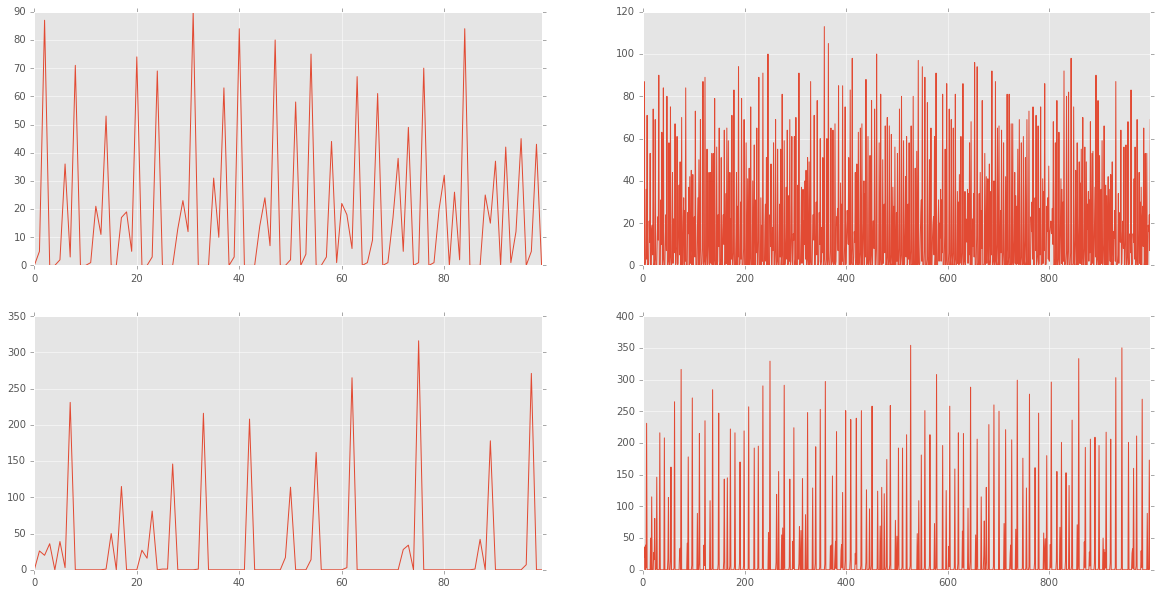

In [5]:
serie1 = p0.rvs(1000).ravel()
serie2 = p1.rvs(1000).ravel()
plt.figure(figsize=(20,10))
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
plt.subplot(223)
ts = pd.Series(serie2)
ts[0:100].plot()
plt.subplot(224)
ts = pd.Series(serie2)
ts.plot()
print serie1.min(),serie1.max()

Generating parametrized training data

In [6]:
theta_values = np.linspace(par_bound[0],par_bound[1], num=15)
for k,value in enumerate(theta_values):
    par_shared.set_value(value)
    theta_array = np.empty((max_len,1))
    theta_array.fill(value)
    X0 = np.array([np.hstack((p0.rvs(max_len, random_state=np.random.randint(0,5000)),theta_array)) 
                   for i in range(n_samples//2)])
    X1 = np.array([np.hstack((p1.rvs(max_len, random_state=np.random.randint(0,5000)),theta_array)) 
                   for i in range(n_samples//2)])
    X_ = np.vstack((X0,X1))
    y_ = np.zeros(X0.shape[0]*2,dtype=np.int)
    y_[X0.shape[0]:] = 1
    X_serie = X_ if k == 0 else np.append(X_serie, X_,axis=0)
    y_serie = y_ if k == 0 else np.append(y_serie, y_,axis=0)

In [7]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD


def make_model():
    model = Sequential()
    model.add(GRU(15,input_shape=(max_len,2)))
    model.add(Dropout(0.3))
    model.add(Dense(5,activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    #sgd = SGD(lr=0.01, clipnorm=40.)
    model.compile(loss="binary_crossentropy", optimizer='adam')
    return model


clf = KerasClassifier(make_model, nb_epoch=10, verbose=2)

clf.fit(X=X_serie, y=y_serie)

Epoch 1/10
48s - loss: 0.0531
Epoch 2/10
50s - loss: 0.0078
Epoch 3/10
50s - loss: 0.0058
Epoch 4/10
53s - loss: 0.0045
Epoch 5/10
53s - loss: 0.0034
Epoch 6/10
50s - loss: 0.0046
Epoch 7/10
50s - loss: 0.0041
Epoch 8/10
52s - loss: 0.0033
Epoch 9/10
53s - loss: 0.0032
Epoch 10/10
52s - loss: 0.0025


Using Theano backend.


In [14]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cc_direct = ClassifierRatio(
    base_estimator=CalibratedClassifierCV(clf, bins=40, cv='prefit', 
                                         method='histogram'), 
    random_state=0)

cc_direct.fit(X=X_serie,y=y_serie)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x968bf90>,
            bins=40, cv='prefit', method='histogram'),
        random_state=0)

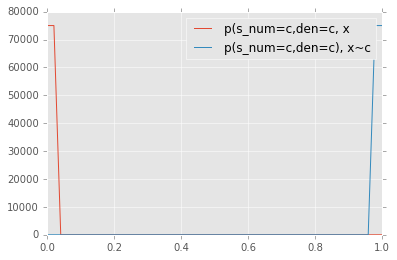

In [15]:
import pdb
reals2 = np.linspace(0, 1)
cal_num, cal_den = cc_direct.classifier_.calibrators_[0].calibrators
plt.plot(reals2, cal_num.pdf(reals2.reshape(-1, 1)), 
         label="p(s_num=c,den=c, x")
plt.plot(reals2, cal_den.pdf(reals2.reshape(-1, 1)), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()


In [10]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio
import pdb

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0, X_true=None):    
    #print(theta)
    # Generating data at parameter point
    par_shared.set_value(theta[0])
    theta_array = np.empty((max_len,1))
    theta_array.fill(theta[0])
    X0 = np.array([np.hstack((p0.rvs(max_len, random_state=i),theta_array)) for i in range(hist_samples//2)])
    
    theta_array_1 = np.empty((max_len,1))
    theta_array_1.fill(theta[0])
    X1 = np.array([np.hstack((p1.rvs(max_len, random_state=i),theta_array_1)) for i in range(hist_samples//2)])
    X_serie = np.vstack((X0,X1))
    
    y_serie = np.zeros(X0.shape[0]*2,dtype=np.int)
    y_serie[X0.shape[0]:] = 1
    
    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="histogram", bins=n_bins))

    ratio.fit(X_serie, y_serie)
    
    # Evaluate log-likelihood ratio
    Xp = np.empty((X_true.shape))
    Xp[:,:] = theta[0]
    X_true_ = np.dstack((X_true, Xp))
    r = ratio.predict(X_true_, log=True)
    zeros = r[np.isinf(r)].shape

    r = r[np.isfinite(r)]
    value = -np.mean(r)

    return value, zeros[0]


Estimating parameters using a grid

In [11]:
n_points = 15
bounds = [par_bound]

par_shared.set_value(par_value)
X_true = np.array([p0.rvs(max_len, random_state = i) for i in range(test_samples)])

As = np.linspace(bounds[0][0],bounds[0][1], n_points)

approx_contours = np.zeros(len(As))
zeroes = np.zeros(len(As))
for i,a in enumerate(As):
    approx_contours[i], zeroes[i] = objective([a],X_true=X_true)


approx_contours = 2. * (approx_contours - approx_contours.min()) * len(X_true)


In [12]:
print(As)
print(approx_contours)

[ 3.5         3.78571429  4.07142857  4.35714286  4.64285714  4.92857143
  5.21428571  5.5         5.78571429  6.07142857  6.35714286  6.64285714
  6.92857143  7.21428571  7.5       ]
[ 1119.43158587   811.09022262   811.21023582   446.52711703   446.32710303
   446.32710303     0.             0.           810.93021622   810.97021662
   810.97021662   810.97021662   810.97021662   810.93021622   810.93021622]


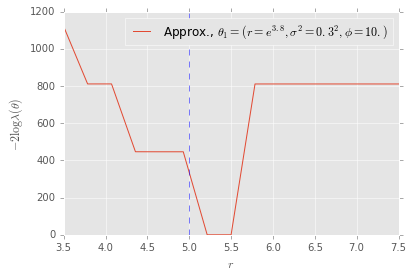

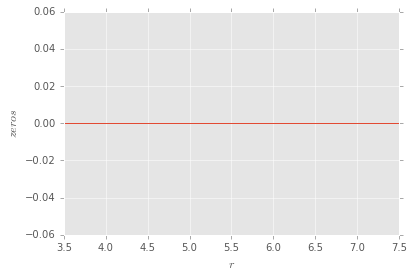

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(As, approx_contours, label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$")
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$-2 \log \lambda(\theta)$")

ax.legend()
ax.set_xlim(bounds[0][0],bounds[0][1])
ax.axvline(x=par_value,linestyle='dashed',alpha=0.5)
plt.show()
plt.plot(As, zeroes)
plt.xlim(bounds[0][0],bounds[0][1])
plt.xlabel(r"$r$")
plt.ylabel(r"$zeros$")
plt.show()

In [ ]:
n_hist = 50
n_points = 30
As = np.linspace(bounds[0][0],bounds[0][1], n_points)

hist_values = np.zeros(n_hist)

for h in range(n_hist):
    par_shared.set_value(par_value)
    X_true = np.array([p0.rvs(max_len, random_state = test_samples*h+i) for i in range(test_samples)])
    approx_contours = np.zeros(len(As))
    zeroes = np.zeros(len(As))
    for i,a in enumerate(As):
        approx_contours[i], zeroes[i] = objective([a], X_true=X_true)
    min_value = As[np.argmin(approx_contours)]
    print '{0} '.format(min_value),
    hist_values[h] = min_value


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(hist_values, range=(bounds[0][0],bounds[0][1]), 
        label=r"Approx., $\theta_1=(r=e^{3.8},\sigma^2=0.3^2,\phi=10.)$", bins=18)
ax.set_xlabel(r"$approx r$")
ax.set_ylabel(r"$Count$")

ax.legend()
ax.axvline(x=r_value,linestyle='dashed',alpha=0.5)
plt.savefig('likelihood_comp.pdf')
plt.show()

TO-DO:
* 2D parameter estimation.
* Parameter estimation on $Y_t$ (here the method must be adapted for state space models).

* Check with other parameters
* Try with an easier model e.g simple autoregresive model